In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms


# 目录：
## 1. Basic autograd example 1
## 2. Basic autograd example 2
## 3. Loading Data from Numpy
## 4. Input pipline
## 5. Input pipline for custom dataset
## 6. Pretrained model
## 7. Save and load model

In [23]:
# 1. Basic autograd example 1
# create tensors
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph. 建立计算图
y = (w * x + b) ** 2

# 计算梯度
y.backward()

# 输出梯度
print("x.grad:", x.grad, " w.grad:", w.grad, " b.grad", b.grad)


x.grad: tensor(20.)  w.grad: tensor(10.)  b.grad tensor(10.)


x的梯度即为y对x求偏导，再代入x的值的结果。

dy/dx = w, dy/dw = x, dy/db = 1

代入x、w、b的值由此可求出x、w、b的梯度

In [39]:
# 2. Basic autograd example 2
# 创建张量
x = torch.randn(45, 5)  # 创建10*3的随机张量 其中填充了标准正态分布的值，即均值为0，方差为1
y = torch.randn(45, 3)  # 创建10*2的随机张量

# 创建全连接层
linear = nn.Linear(5, 3)
print("w: ", linear.weight)
print("b: ", linear.bias)

# 创建损失函数和optimizer
criterion =  nn.MSELoss()  # 使用MSE（均方误差）损失函数
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01) # 使用SGD（随机梯度下降）作为优化器，学习率为0.01

# 前向传递
pred = linear(x) # 等价于pred = torch.mm(x, linear.weight.T) + linear.bias 这里相加使用了广播机制
#print("pred:", pred, "\nwx+b:", torch.mm(x, linear.weight.T))
# 计算误差
loss = criterion(pred, y)
print("loss: ", loss.item())
loss2 = torch.mean((pred-y)**2) # 
print("loss2:", loss2.item())
# 反向传递
loss.backward()

# 理论计算梯度： 需要注意向量对标量求导、向量对向量求导的区别 https://wenku.baidu.com/view/a3cba05602f69e3143323968011ca300a6c3f6a2.html
w_theory_grad = torch.div(2*torch.mm((pred - y).T, x), y.shape[0] * y.shape[1])
b_theory_grad = torch.div(2*torch.sum((pred - y), dim=0), y.shape[0] * y.shape[1])
print("theory_grad:dL/dw = 2*(pred - y) * x / n, where n means the length of y(here is 20 * 3): \n", w_theory_grad)
print("theory_grad:dL/db = 2*(pred - y) / n: \n", b_theory_grad)
# 打印梯度
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

print("wnew:", linear.weight - 0.01 * linear.weight.grad)
print("bnew:", linear.bias - 0.01 * linear.bias.grad)
# 进行一步的梯度下降
optimizer.step()   # wnew = wold - lr * dL/dw

# You can also perform gradient descent at the low level.
# linear.weight.data.sub_(0.01 * linear.weight.grad.data)
# linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# 再打印更新参数后的损失
pred = linear(x)
loss = criterion(pred, y)
print("loss after 1 step optimization: ", loss.item())
print("w: ", linear.weight, " b:", linear.bias) # linear.weight == wnew

w:  Parameter containing:
tensor([[-0.0146, -0.2289, -0.2957,  0.4126,  0.2726],
        [ 0.0514,  0.0362, -0.3249, -0.3307,  0.0771],
        [-0.3290,  0.1781, -0.1378,  0.3778,  0.1981]], requires_grad=True)
b:  Parameter containing:
tensor([-0.4289,  0.1331,  0.4228], requires_grad=True)
loss:  1.2896790504455566
loss2: 1.2896790504455566
theory_grad:dL/dw = 2*(pred - y) * x / n, where n means the length of y(here is 20 * 3): 
 tensor([[ 0.0173, -0.1220, -0.2418,  0.2516,  0.1707],
        [-0.0826, -0.0309, -0.2013, -0.0494, -0.0718],
        [-0.1695,  0.2735, -0.3993,  0.1538,  0.2530]], grad_fn=<DivBackward0>)
theory_grad:dL/db = 2*(pred - y) / n: 
 tensor([-0.1025,  0.0395,  0.2876], grad_fn=<DivBackward0>)
dL/dw:  tensor([[ 0.0173, -0.1220, -0.2418,  0.2516,  0.1707],
        [-0.0826, -0.0309, -0.2013, -0.0494, -0.0718],
        [-0.1695,  0.2735, -0.3993,  0.1538,  0.2530]])
dL/db:  tensor([-0.1025,  0.0395,  0.2876])
wnew: tensor([[-0.0148, -0.2277, -0.2933,  0.4101,  0.2

In [4]:
# 3. load data from numpy

x = np.array([[1, 2], [3, 4]])

# convert the numpy array to a torch tensor
y = torch.from_numpy(x)

# convert the torch tensor to a numpy array
z = y.numpy()

print("y: ", y)
print("z: ", z)

y:  tensor([[1, 2],
        [3, 4]])
z:  [[1 2]
 [3 4]]


In [5]:
# 4. Input pipeline

# Download and construct CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=True, transform=transforms.ToTensor(), download=True)

# Fetch one data pair (read data from disk)
image, label = train_dataset[0]
print(image.size())
print(label)

Extracting ../../data/cifar-10-python.tar.gz to ../../data/
torch.Size([3, 32, 32])
6


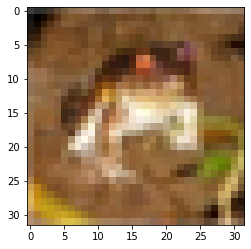

In [12]:
# 显示读到的图片
import matplotlib.pyplot as plt
unloader = transforms.ToPILImage()
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

img_t_i=tensor_to_PIL(image)
# img_t_i
plt.imshow(img_t_i)

In [20]:
# Data loader (this provides queues and threads in a very simple way)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# 迭代开始时，队列和进程从文件中读取数据
data_iter = iter(train_loader)

# Mini-batch images and labels
images, labels = data_iter.next()

# 实际对data_loader的使用如下
for images, labels in train_loader:
    # 下面应该是训练代码
    # 好玩：显示图片
#     f = plt.figure()
#     for i in range(len(images)):
#         f.add_subplot(1, 64, i+1)
#         img_t_i=tensor_to_PIL(images[i])
#         # img_t_i
#         plt.imshow(img_t_i)
#         plt.show(block=True)
#     break
    pass

In [22]:
# 5.Input pipeline for custom dataset
# You should build your custom dataset as below
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        # TODO
        # 1. Initialize file paths or a list of file names.
        pass
    def __getitem__(self, index):
        # TODO
        # 1.Read one data from file(e.g. using numpy.fromfile, PIL.Image.open).
        # 2.Preprocess the data(e.g. torchvision.Transform).
        # 3.Return a data pair(e.g. image and label)
        pass
    def __len__(self):
        # You should change 0 to the total size of your dataset
        return 0
    
# You can then use the prebuilt data loader
custom_dataset = CustomDataset()
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                          batch_size=64,
                                          shuffle=True)

In [24]:
# 6.Pretrained model
# Download and load the pretrained ResNet-18
resnet = torchvision.models.resnet18(pretrained=True)

# If you want to finetune only the top layer of the model, set as below:
for param in resnet.parameters():
    param.requires_grad = False

# Replace the top layer for finetuning
resnet.fc = nn.Linear(resnet.fc.in_features, 100) # 100 is an example

# Forward pass
images = torch.randn(64, 3, 224, 224)
outputs = resnet(images)
print(outputs.size()) # (64, 100)

torch.Size([64, 100])


In [25]:
# 7.save and load the model
# save and load the entire model
torch.save(resnet, 'model.ckpt')
model = torch.load('model.ckpt')

# Save and load only the model parameters (recommended)
torch.save(resnet.state_dict(), 'params.ckpt')
resnet.load_state_dict(torch.load('params.ckpt'))

<All keys matched successfully>